In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('fmcg.csv', index_col=['date'])
prices.head(10)

HINDUNILVR.NS      ITC.NS  NESTLEIND.NS  TATACONSUM.NS  \
date                                                                 
01-01-2018    1344.500000  262.299988   7863.200195     312.899994   
02-01-2018    1338.599976  260.750000   7863.549805     311.149994   
03-01-2018    1350.349976  261.149994   7860.100098     311.200012   
04-01-2018    1352.250000  261.549988   7869.250000     312.250000   
05-01-2018    1356.550049  262.899994   7856.750000     312.950012   
08-01-2018    1368.400024  265.600006   7941.149902     317.600006   
09-01-2018    1361.300049  270.549988   7779.250000     315.299988   
10-01-2018    1365.800049  269.399994   7846.649902     314.100006   
11-01-2018    1378.650024  269.799988   7874.299805     313.299988   
12-01-2018    1374.000000  267.549988   7789.250000     325.750000   

            BRITANNIA.NS  GODREJCP.NS    DABUR.NS  MCDOWELL-N.NS   MARICO.NS  \
date                                                                           
01-01-2018   2369.125000   657.500000  349.000000     728.760010  320.700012   
02-01-2018   2328.024902   654.366638  349.049988     718.400024  325.700012   
03-01-2018   2340.475098   657.599976  354.649994     719.630005  320.850006   
04-01-2018   2313.199951   659.633362  355.000000     737.770019  323.350006   
05-01-2018   2322.050049   660.033325  358.200012     790.650024  326.950012   
08-01-2018   2346.875000   663.133362  361.350006     784.700012  323.149994   
09-01-2018   2320.975098   658.833313  359.350006     768.909973  323.850006   
10-01-2018   2337.375000   652.299988  357.799988     766.080017  321.649994   
11-01-2018   2360.774902   656.666687  359.899994     765.530029  316.299988   
12-01-2018   2354.149902   660.866638  358.149994     761.849976  312.700012   

              COLPAL.NS  
date                     
01-01-2018  1102.599976  
02-01-2018  1100.750000  
03-01-2018  1098.349976  
04-01-2018  1094.349976  
05-01-2018  1100.699951  
08-01-2018  1117.699951  
09-01-2018  1120.599976  
10-01-2018  1118.250000  
11-01-2018  1125.050049  
12-01-2018  1139.599976

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

HINDUNILVR.NS      ITC.NS  NESTLEIND.NS  TATACONSUM.NS  \
date                                                                 
01-01-2018    1344.500000  262.299988   7863.200195     312.899994   
02-01-2018    1338.599976  260.750000   7863.549805     311.149994   
30-12-2020    2406.600098  211.149994  18379.250000     594.349976   
31-12-2020    2395.399902  209.000000  18390.250000     589.900024   

            BRITANNIA.NS  GODREJCP.NS    DABUR.NS  MCDOWELL-N.NS   MARICO.NS  \
date                                                                           
01-01-2018   2369.125000   657.500000  349.000000     728.760010  320.700012   
02-01-2018   2328.024902   654.366638  349.049988     718.400024  325.700012   
30-12-2020   3583.899902   749.150024  539.549988     577.750000  403.450012   
31-12-2020   3576.350098   740.150024  534.000000     578.250000  402.649994   

              COLPAL.NS  
date                     
01-01-2018  1102.599976  
02-01-2018  1100.750000  
30-12-2020  1579.000000  
31-12-2020  1565.250000

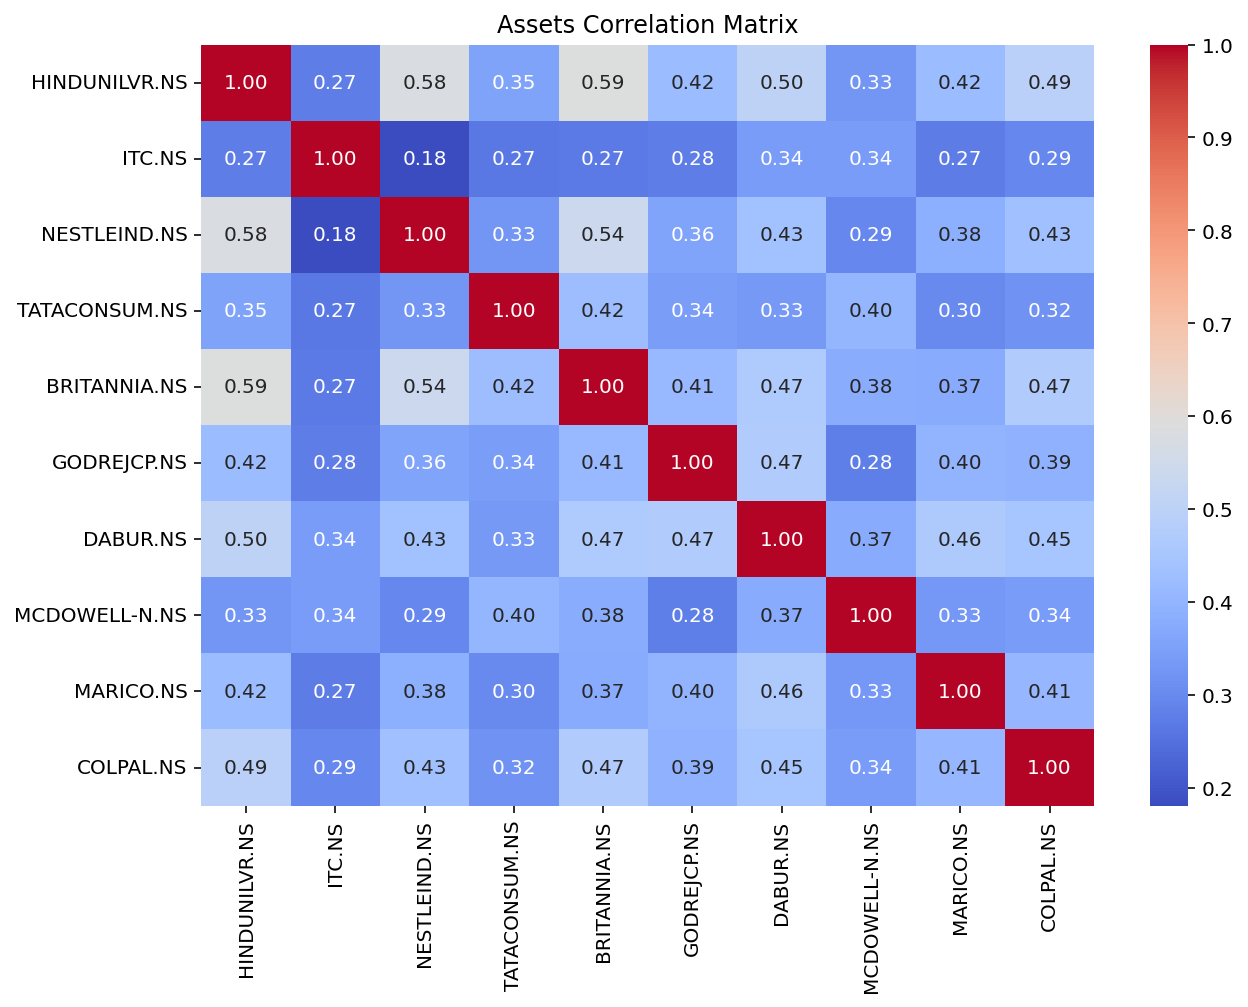

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('HINDUNILVR.NS', 'NESTLEIND.NS'), ('HINDUNILVR.NS', 'DABUR.NS'), ('MCDOWELL-N.NS', 'MARICO.NS'), ('MCDOWELL-N.NS', 'COLPAL.NS')]


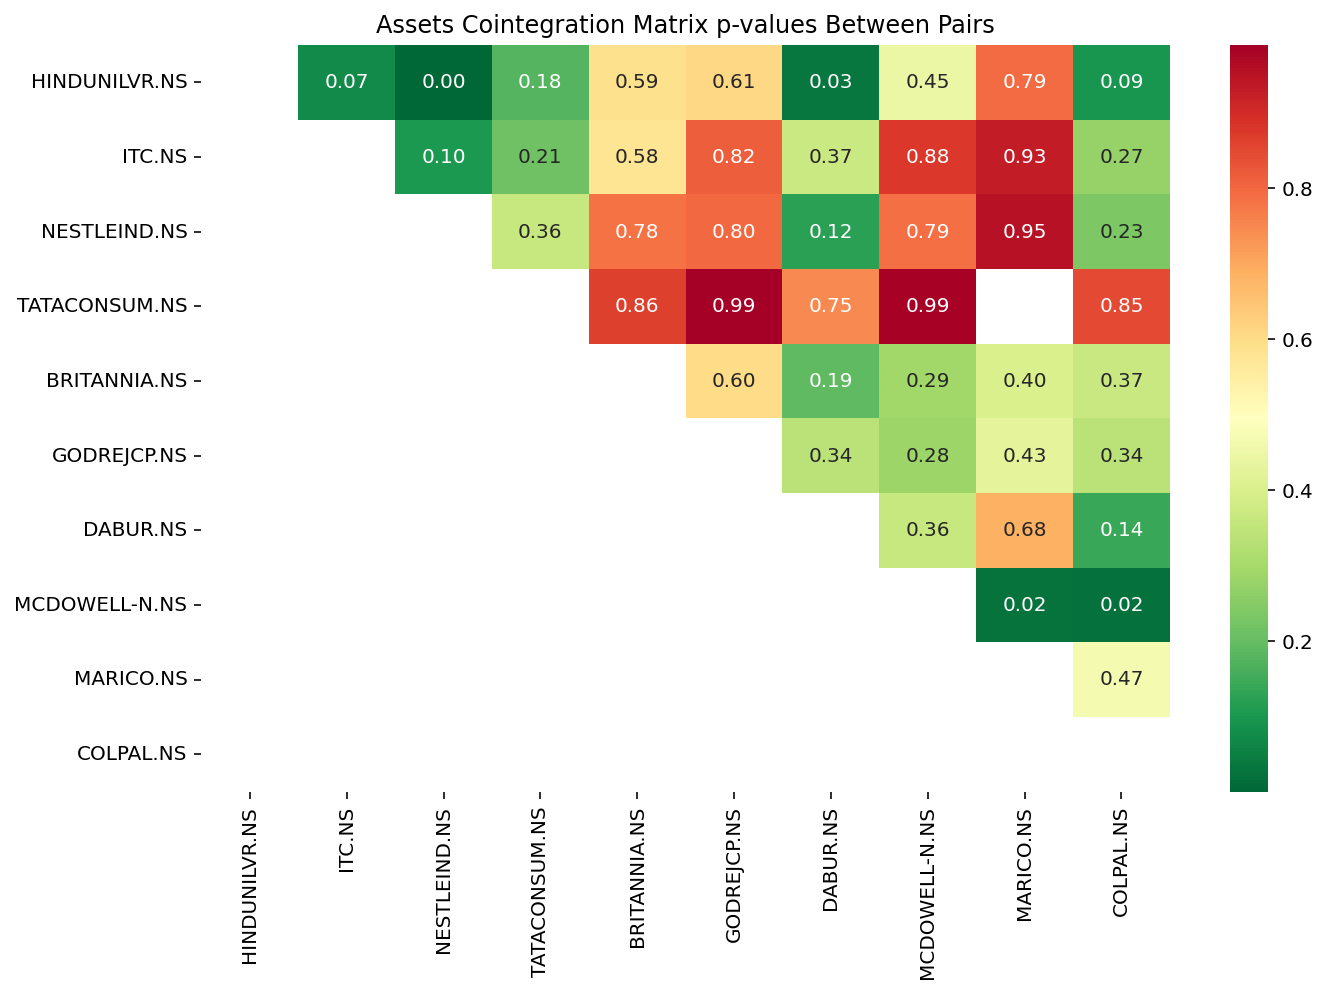

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'HINDUNILVR.NS'
asset2 = 'COLPAL.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

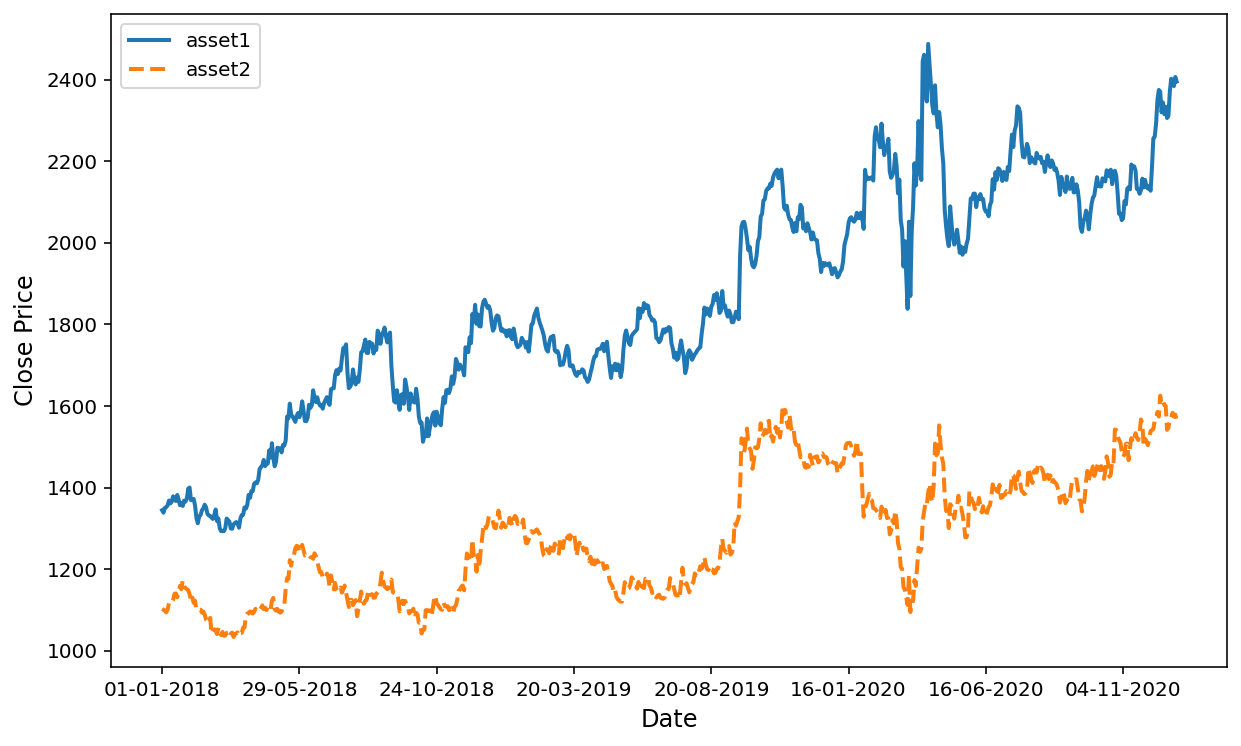

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1']].plot(figsize=(10, 6), linewidth=2,linestyle='solid', label = "asset1")
plt.plot(train[['asset2']], linewidth=2, linestyle='dashed', label = "asset2")
ax.set_ylabel("Close Price", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
plt.legend()
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
#ax.grid(True);
plt.savefig('chart3', dpi=500) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.083e+05
Date:                Thu, 12 May 2022   Prob (F-statistic):                        0.00
Time:                        15:02:01   Log-Likelihood:                         -4503.8
No. Observations:                 740   AIC:                                      9010.
Df Residuals:                     739   BIC:                                      9014.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.6868      0.002    329.100      0.000       0.683       0.691
==============================================================================
Omnibus:                       26.216   Durbin-Watson:                   0.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.081
Skew:                          -0.470   Prob(JB):                     7.98e-07
Kurtosis:                       3.166   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

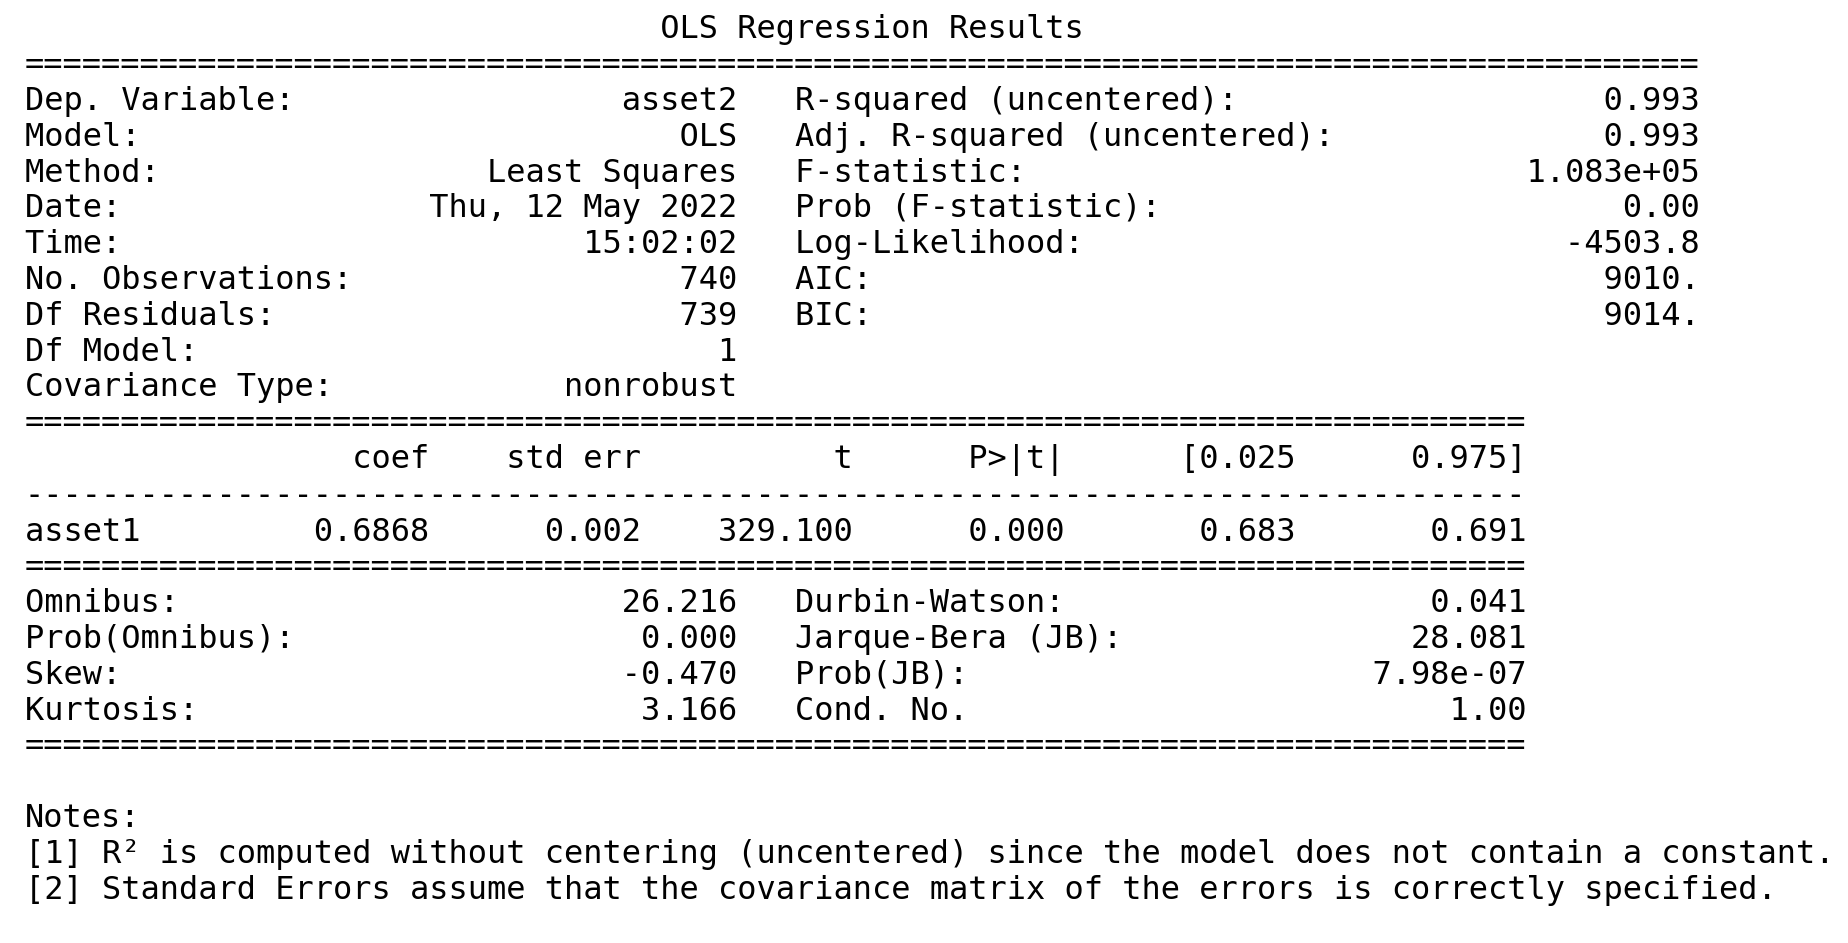

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [17]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.6868119388341689


In [18]:
# calculate spread
residual = train.asset2 - model.params[0] * train.asset1

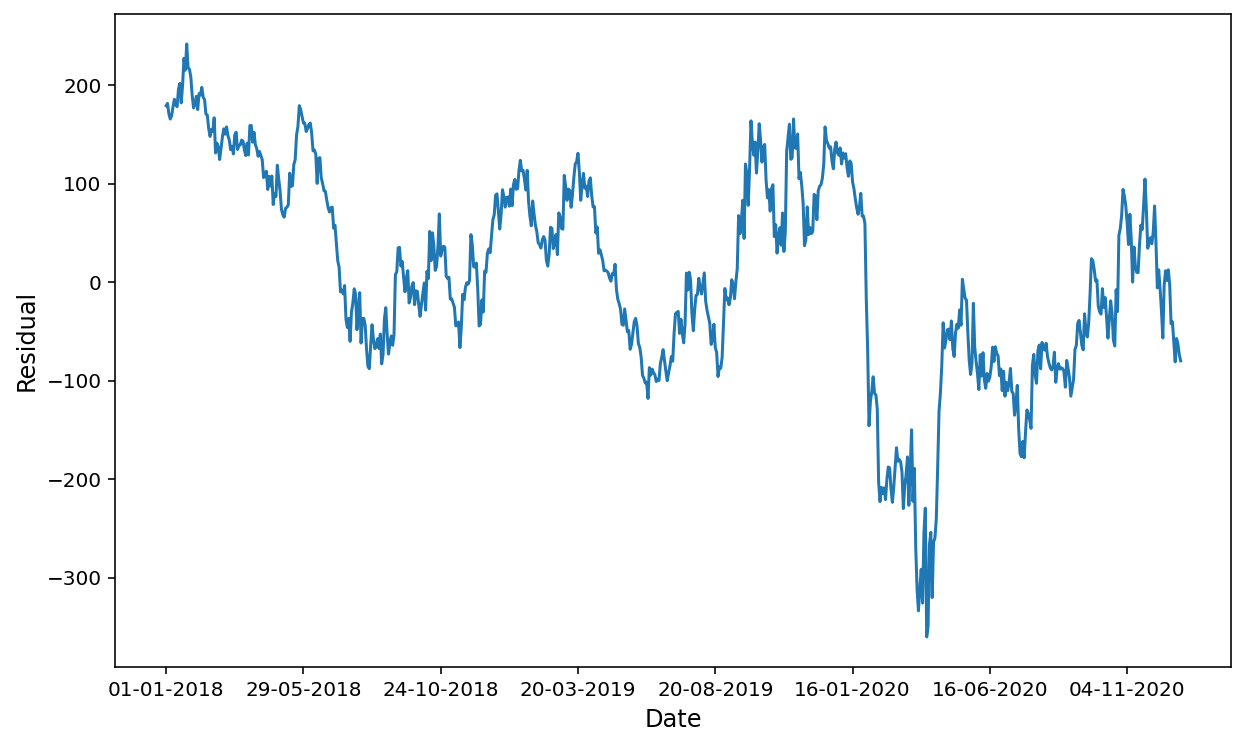

In [19]:
# Plot the residual
ax = residual.plot(figsize=(10, 6))
ax.set_ylabel("Residual", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
# ax.grid(True);
plt.savefig('chart5', dpi=500);

In [32]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-2.744578993954693,
 0.0666366890750264,
 1,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 6623.321292928783)

In [33]:
print('Critical Value = ', adf[0])

Critical Value =  -2.744578993954693


In [35]:
# probablity critical values
print(adf[4])

{'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}


### Generate Trading Signals using z-score

In [36]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [37]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [38]:
signals.head()

asset1       asset2
date                                
01-01-2021  2387.550049  1578.449951
04-01-2021  2426.500000  1576.099976
05-01-2021  2450.550049  1598.949951
06-01-2021  2417.300049  1597.599976
07-01-2021  2368.850098  1592.099976

In [39]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [40]:
signals.head()

asset1       asset2         z  z upper limit  z lower limit
date                                                                        
01-01-2021  2387.550049  1578.449951  0.068205            1.0           -1.0
04-01-2021  2426.500000  1576.099976  0.354083            1.0           -1.0
05-01-2021  2450.550049  1598.949951  0.280301            1.0           -1.0
06-01-2021  2417.300049  1597.599976  0.073406            1.0           -1.0
07-01-2021  2368.850098  1592.099976 -0.193776            1.0           -1.0

In [41]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [42]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

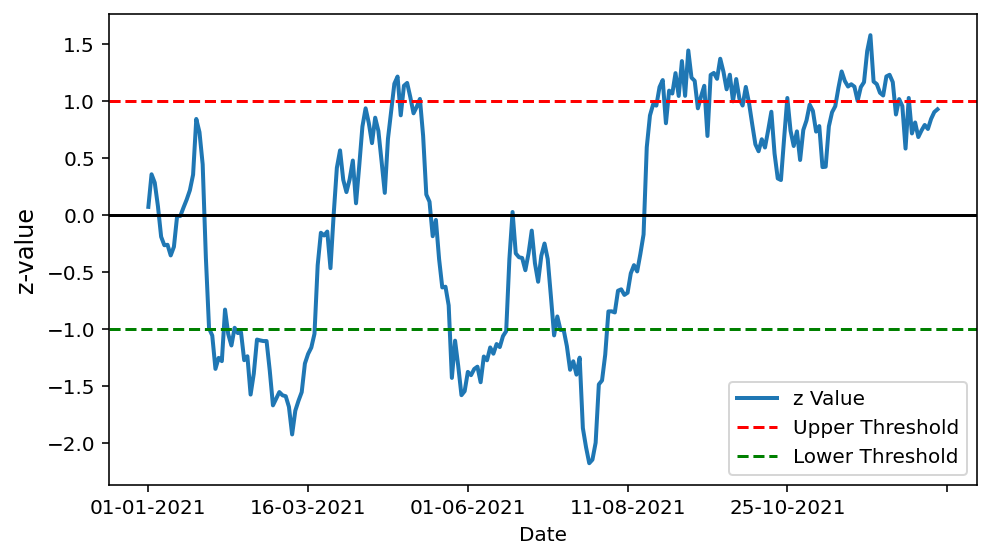

In [43]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value", figsize=(7, 4), linewidth=2)
#plt.title("Z-score Evaluation")
plt.ylabel("z-value", fontsize=12)
plt.xlabel("Date")
plt.axhline(signals['z'].mean(),linestyle= 'solid', color="black")
plt.axhline(signals['z upper limit'].mean(), linestyle= 'dashed',color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), linestyle = 'dashed', color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=500);

In [44]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  2387.550049  1578.449951  0.068205            1.0           -1.0   
04-01-2021  2426.500000  1576.099976  0.354083            1.0           -1.0   
05-01-2021  2450.550049  1598.949951  0.280301            1.0           -1.0   
29-12-2021  2306.850098  1455.099976  0.839540            1.0           -1.0   
30-12-2021  2325.600098  1461.699951  0.899637            1.0           -1.0   
31-12-2021  2360.149902  1481.300049  0.923722            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [45]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-02-2021  2248.600098  1599.099976 -1.059967            1.0           -1.0   
02-02-2021  2230.449951  1617.949951 -1.352549            1.0           -1.0   
03-02-2021  2232.850098  1609.099976 -1.256363            1.0           -1.0   
04-02-2021  2245.600098  1621.400024 -1.284594            1.0           -1.0   
08-02-2021  2236.649902  1589.250000 -1.047290            1.0           -1.0   
09-02-2021  2216.250000  1585.400024 -1.147463            1.0           -1.0   
11-02-2021  2263.000000  1607.050049 -1.038722            1.0           -1.0   
12-02-2021  2241.550049  1591.050049 -1.031521            1.0           -1.0   
15-02-2021  2215.199951  1598.550049 -1.276328            1.0           -1.0   
16-02-2021  2196.100098  1581.050049 -1.241792            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-02-2021         1         1.0        -1        -1.0  
02-02-2021         1         0.0        -1         0.0  
03-02-2021         1         0.0        -1         0.0  
04-02-2021         1         0.0        -1         0.0  
08-02-2021         1         1.0        -1        -1.0  
09-02-2021         1         0.0        -1         0.0  
11-02-2021         1         1.0        -1        -1.0  
12-02-2021         1         0.0        -1         0.0  
15-02-2021         1         0.0        -1         0.0  
16-02-2021         1         0.0        -1         0.0

In [46]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  2387.550049  1578.449951  0.068205            1.0           -1.0   
01-02-2021  2248.600098  1599.099976 -1.059967            1.0           -1.0   
05-02-2021  2269.550049  1589.750000 -0.832602            1.0           -1.0   
08-02-2021  2236.649902  1589.250000 -1.047290            1.0           -1.0   
10-02-2021  2235.500000  1582.599976 -0.992304            1.0           -1.0   
14-12-2021  2318.300049  1458.949951  0.878386            1.0           -1.0   
15-12-2021  2320.949951  1449.000000  1.013440            1.0           -1.0   
16-12-2021  2309.500000  1447.099976  0.951858            1.0           -1.0   
20-12-2021  2269.100098  1415.800049  1.023386            1.0           -1.0   
21-12-2021  2272.850098  1444.599976  0.712197            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
01-02-2021         1         1.0        -1        -1.0  
05-02-2021         0        -1.0         0         1.0  
08-02-2021         1         1.0        -1        -1.0  
10-02-2021         0        -1.0         0         1.0  
14-12-2021         0         1.0         0        -1.0  
15-12-2021        -1        -1.0         1         1.0  
16-12-2021         0         1.0         0        -1.0  
20-12-2021        -1        -1.0         1         1.0  
21-12-2021         0         1.0         0        -1.0

In [47]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

2248.600098    1
2236.649902    1
2309.500000    1
2318.300049    1
2335.100098    1
2436.850098    1
2686.050049    1
2686.199951    1
2685.300049    1
2722.250000    1
2762.550049    1
2687.699951    1
2444.149902    1
2447.550049    1
2344.050049    1
2402.100098    1
2390.000000    1
2353.750000    1
2263.000000    1
2272.850098    1
Name: asset1, dtype: int64

In [48]:
signals

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  2387.550049  1578.449951  0.068205            1.0           -1.0   
04-01-2021  2426.500000  1576.099976  0.354083            1.0           -1.0   
05-01-2021  2450.550049  1598.949951  0.280301            1.0           -1.0   
06-01-2021  2417.300049  1597.599976  0.073406            1.0           -1.0   
07-01-2021  2368.850098  1592.099976 -0.193776            1.0           -1.0   
...                 ...          ...       ...            ...            ...   
27-12-2021  2301.399902  1456.250000  0.786594            1.0           -1.0   
28-12-2021  2309.100098  1464.199951  0.751382            1.0           -1.0   
29-12-2021  2306.850098  1455.099976  0.839540            1.0           -1.0   
30-12-2021  2325.600098  1461.699951  0.899637            1.0           -1.0   
31-12-2021  2360.149902  1481.300049  0.923722            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [49]:
signals = signals.reset_index()

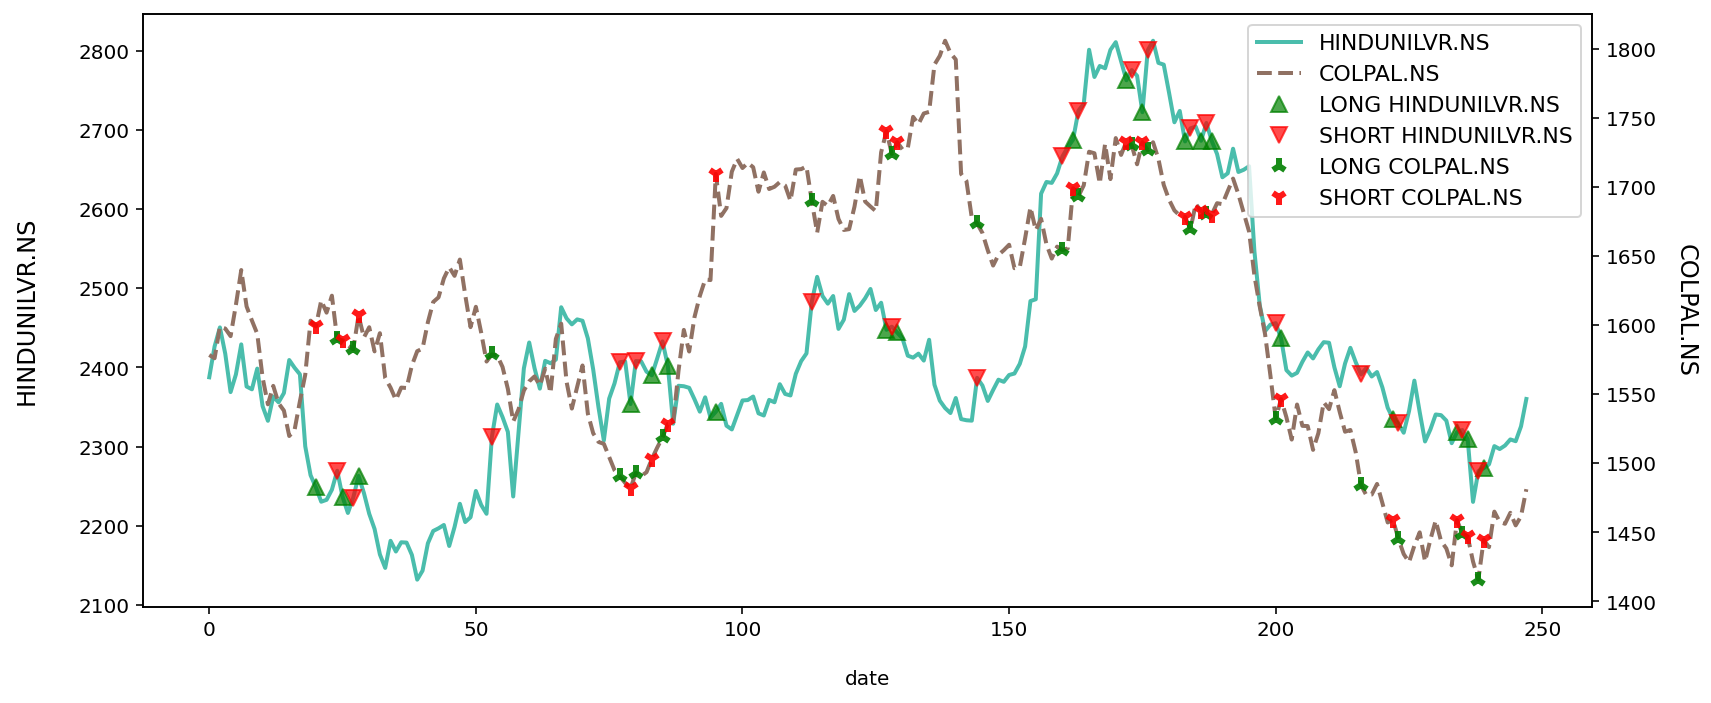

In [51]:
# visualize trading signals and position
fig=plt.figure(figsize=(12,5))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac', linestyle = 'solid', linewidth=2)
l2, = bx2.plot(signals['asset2'], c='#907163', linestyle = 'dashed', linewidth=2)

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, 
              marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,
              marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,
               marker='2',markersize=8, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,
               marker='1',markersize=8, c='r',alpha=0.9,markeredgewidth=3)
bx.set_ylabel(asset1,fontsize=12)
bx2.set_ylabel(asset2, rotation=270, fontsize=12)
bx.yaxis.labelpad=20
bx2.yaxis.labelpad=20
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best', fontsize = 11)

#plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date', fontsize=12)
#plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=500);

### Portfolio Profit and Loss Calculation

In [52]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [53]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [54]:
portfolio.head().append(portfolio.tail())

asset1  holdings1          cash1   total asset1  return1  positions1
0    2387.550049        NaN            NaN            NaN      NaN         NaN
1    2426.500000        0.0  100000.000000  100000.000000      NaN         0.0
2    2450.550049        0.0  100000.000000  100000.000000      0.0         0.0
3    2417.300049        0.0  100000.000000  100000.000000      0.0         0.0
4    2368.850098        0.0  100000.000000  100000.000000      0.0         0.0
243  2301.399902        0.0  117375.731135  117375.731135      0.0         0.0
244  2309.100098        0.0  117375.731135  117375.731135      0.0         0.0
245  2306.850098        0.0  117375.731135  117375.731135      0.0         0.0
246  2325.600098        0.0  117375.731135  117375.731135      0.0         0.0
247  2360.149902        0.0  117375.731135  117375.731135      0.0         0.0

In [55]:
portfolio[portfolio.positions1 != 0].head()

asset1    holdings1          cash1   total asset1   return1  \
0   2387.550049          NaN            NaN            NaN       NaN   
20  2248.600098  78701.00343   21298.996570  100000.000000  0.000000   
24  2269.550049      0.00000  100733.248285  100733.248285  0.008391   
25  2236.649902  78282.74657   22450.501715  100733.248285  0.000000   
27  2235.500000      0.00000  100693.001715  100693.001715  0.006736   

    positions1  
0          NaN  
20         1.0  
24        -1.0  
25         1.0  
27        -1.0

In [56]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [57]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1  holdings1          cash1   total asset1  return1  \
0    2387.550049        NaN            NaN            NaN      NaN   
1    2426.500000        0.0  100000.000000  100000.000000      NaN   
2    2450.550049        0.0  100000.000000  100000.000000      0.0   
3    2417.300049        0.0  100000.000000  100000.000000      0.0   
4    2368.850098        0.0  100000.000000  100000.000000      0.0   
243  2301.399902        0.0  117375.731135  117375.731135      0.0   
244  2309.100098        0.0  117375.731135  117375.731135      0.0   
245  2306.850098        0.0  117375.731135  117375.731135      0.0   
246  2325.600098        0.0  117375.731135  117375.731135      0.0   
247  2360.149902        0.0  117375.731135  117375.731135      0.0   

     positions1       asset2  holdings2          cash2   total asset2  \
0           NaN  1578.449951        NaN            NaN            NaN   
1           0.0  1576.099976        0.0  100000.000000  100000.000000   
2           0.0  1598.949951        0.0  100000.000000  100000.000000   
3           0.0  1597.599976        0.0  100000.000000  100000.000000   
4           0.0  1592.099976        0.0  100000.000000  100000.000000   
243         0.0  1456.250000        0.0  112729.740485  112729.740485   
244         0.0  1464.199951        0.0  112729.740485  112729.740485   
245         0.0  1455.099976        0.0  112729.740485  112729.740485   
246         0.0  1461.699951        0.0  112729.740485  112729.740485   
247         0.0  1481.300049        0.0  112729.740485  112729.740485   

     return2  positions2  
0        NaN         NaN  
1        NaN         0.0  
2        0.0         0.0  
3        0.0         0.0  
4        0.0         0.0  
243      0.0         0.0  
244      0.0         0.0  
245      0.0         0.0  
246      0.0         0.0  
247      0.0         0.0

In [58]:
portfolio[portfolio.positions2 != 0].head()

asset1    holdings1          cash1   total asset1   return1  \
0   2387.550049          NaN            NaN            NaN       NaN   
20  2248.600098  78701.00343   21298.996570  100000.000000  0.000000   
24  2269.550049      0.00000  100733.248285  100733.248285  0.008391   
25  2236.649902  78282.74657   22450.501715  100733.248285  0.000000   
27  2235.500000      0.00000  100693.001715  100693.001715  0.006736   

    positions1       asset2    holdings2         cash2  total asset2  \
0          NaN  1578.449951          NaN           NaN           NaN   
20         1.0  1599.099976 -87950.49868  187950.49868  100000.00000   
24        -1.0  1589.750000      0.00000  100514.24868  100514.24868   
25         1.0  1589.250000 -87408.75000  187922.99868  100514.24868   
27        -1.0  1582.599976      0.00000  100880.00000  100880.00000   

         return2  positions2  
0            NaN         NaN  
20  2.220446e-16        -1.0  
24  1.762367e-02         1.0  
25  2.220446e-16        -1.0  
27  1.528926e-03         1.0

In [59]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

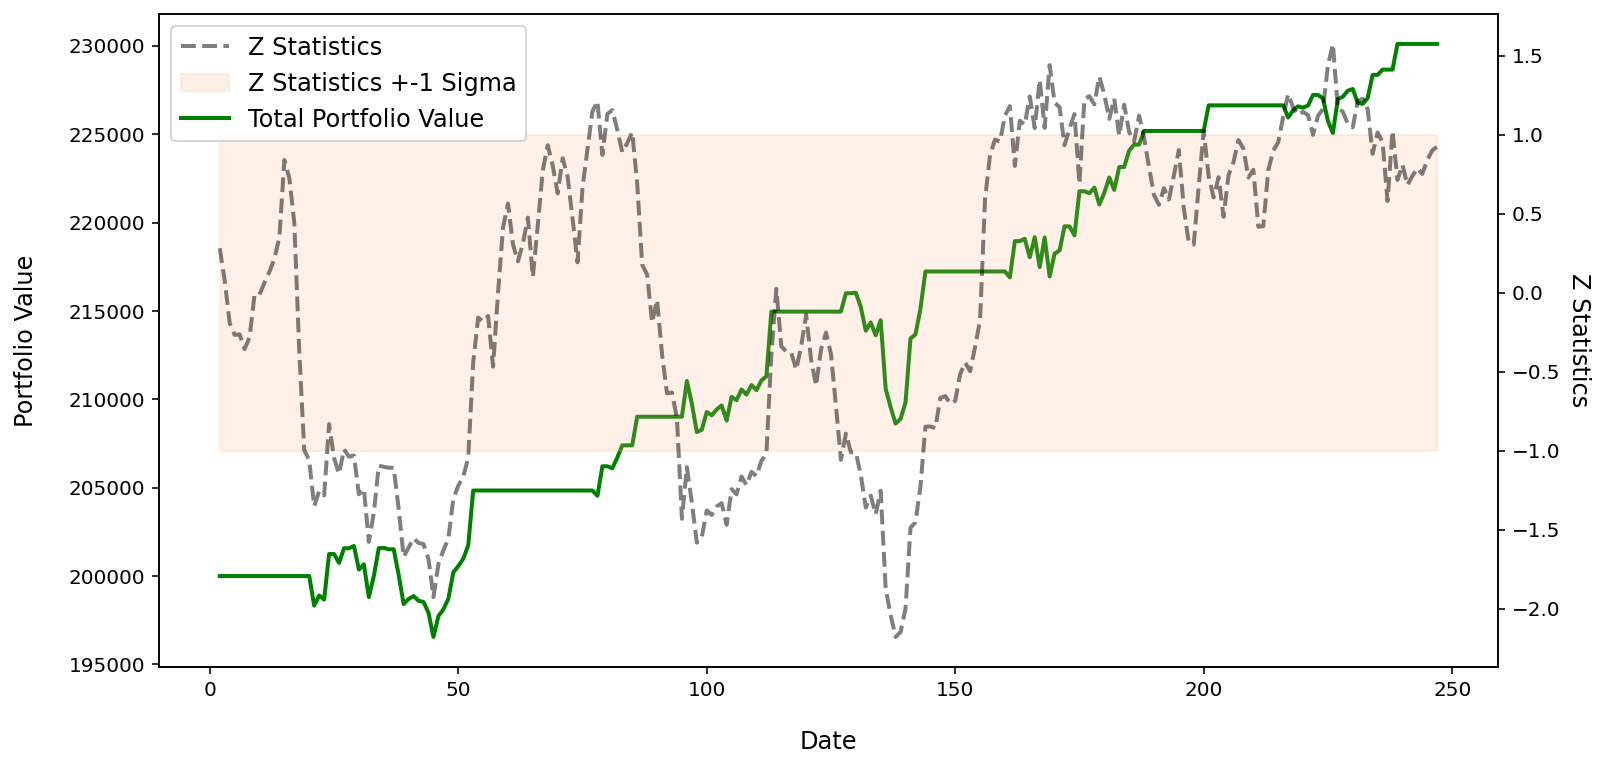

In [62]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(12,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g', linewidth = 2, linestyle='solid')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.5, linewidth = 2, 
               linestyle='dashed')

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value', fontsize=12)
ax2.set_ylabel('Z Statistics',rotation=270, fontsize=12)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date', fontsize=12)
ax.xaxis.labelpad=15
#plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left', fontsize=12);
plt.savefig('chart8', dpi=500);

In [54]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

230105.47162000003

In [55]:
profit = final_portfolio - 2*initial_capital
profit

30105.471620000026

In [56]:
roi = (profit/(2*initial_capital))*100
roi

15.052735810000012

In [57]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

Number of days =  245


In [58]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 246.097%
